<a href="https://colab.research.google.com/github/donnedarnall/crop_weed_stem_classification/blob/main/segformer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Semantic segmentation of crop and weed stems with SegFormer and Hugging Face Transformers
**Author:** Donné D'Arnall<br>
**Date created:** 02/03/2025<br>
**Last modified:** 02/03/2025<br>
**Description:** Fine-tuning a SegFormer model variant for semantic segmentation of crop and weed stem emergence points with Nexus Robotics crop row data.<br>

Inspiration and parts borrowed from https://github.com/NielsRogge/Transformers-Tutorials/blob/master/SegFormer/Fine_tune_SegFormer_on_custom_dataset.ipynb


Install transformers library

In [22]:
!pip install -q transformers evaluate torchmetrics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 927.3/927.3 kB 20.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 1.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 80.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 71.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 43.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 14.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 7.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 79.7 MB/s eta 0:00:00


## Define PyTorch dataset and dataloaders

Here we define a [custom PyTorch dataset](https://pytorch.org/tutorials/beginner/data_loading_tutorial.html). Each item of the dataset consists of an image and a corresponding segmentation map.

In [2]:
from torch.utils.data import Dataset
import os
from PIL import Image
import numpy as np

class SemanticSegmentationDataset(Dataset):
    """Image (semantic) segmentation dataset."""

    def __init__(self, root_dir, image_processor, color_map, train=True):
        """
        Args:
            root_dir (string): Root directory of the dataset containing the images + annotations.
            image_processor (SegFormerImageProcessor): image processor to prepare images + segmentation maps.
            train (bool): Whether to load "training" or "validation" images + annotations.
        """
        self.root_dir = root_dir
        self.image_processor = image_processor
        self.train = train
        self.color_map = color_map

        sub_path = "training2" if self.train else "validation2"
        #self.img_dir = os.path.join(self.root_dir, "img")
        #self.ann_dir = os.path.join(self.root_dir, "stems_labels")
        self.img_dir = os.path.join(self.root_dir, "images", sub_path)
        self.ann_dir = os.path.join(self.root_dir, "annotations", sub_path)

        # import os

        CAM = 'overhead'
        '''
        # read images
        image_file_names = []
        for root, dirs, files in os.walk(self.img_dir):
          if root == self.img_dir:  # Only process the top-level directory
                for file in files:
                    if CAM in file:  # Filter files containing 'CAM'
                        image_file_names.append(os.path.join(root, file))  # Store full path
                break  # Stop after the first (top-level) directory
        self.images = sorted(image_file_names)

        # read annotations
        annotation_file_names = []
        for root, dirs, files in os.walk(self.ann_dir):
          if root == self.ann_dir:  # Only process the top-level directory
                for file in files:
                    if CAM in file:  # Filter files containing 'CAM'
                        annotation_file_names.append(os.path.join(root, file))  # Store full path
                break  # Stop after the first (top-level) directory
        self.annotations = sorted(annotation_file_names)
        '''

        #self.images = ['1565561922505012000-overhead-image.png']
        #self.annotations = ['1565561922505012000-overhead-image.png']



        # read images
        image_file_names = []
        for root, dirs, files in os.walk(self.img_dir):
          image_file_names.extend(files)
        self.images = sorted(image_file_names)

        # read annotations
        annotation_file_names = []
        for root, dirs, files in os.walk(self.ann_dir):
          annotation_file_names.extend(files)
        self.annotations = sorted(annotation_file_names)


        assert len(self.images) == len(self.annotations), "There must be as many images as there are segmentation maps"
    '''
    def __get_img_files__(self, basepath, cam):
        image_file_names = []
        for root, dirs, files in os.walk(basepath):
            if root == basepath:  # Only process the top-level directory
                for file in files:
                    if cam in file:  # Filter files containing 'cam'
                        image_file_names.append(os.path.join(root, file))  # Store full path
                break  # Stop after the first (top-level) directory
        return sorted(image_file_names)

    '''
    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):

        #print('get item')
        #print('self: ')
        #print(self)
        #print('--------------')

        image = Image.open(os.path.join(self.img_dir, self.images[idx]))
        #print('image: ')
        #print(image)
        #print('--------------')
        segmentation_map = Image.open(os.path.join(self.ann_dir, self.annotations[idx]))
        #print('segmentation_map: ')
        #print(segmentation_map)
        #print('--------------')

        """
        Converts an RGB segmentation map to class labels based on the provided color_map.

        Args:
            segmentation_map (PIL.Image): The RGB segmentation map.
            color_map (dict): Mapping from RGB tuples to class indices.

        Returns:
            np.ndarray: 2D array of class labels.
        """
        seg_map_np = np.array(segmentation_map)  # Convert to NumPy array
        class_labels = np.zeros((seg_map_np.shape[0], seg_map_np.shape[1]), dtype=np.int64)

        for rgb, class_id in self.color_map.items():
            mask = np.all(seg_map_np == rgb, axis=-1)
            class_labels[mask] = class_id

        # randomly crop + pad both image and segmentation map to same size
        encoded_inputs = self.image_processor(image, class_labels, return_tensors="pt")

        #print('encoded_inputs: ')
        #print(encoded_inputs)
        #print('--------------')
        for k,v in encoded_inputs.items():
          encoded_inputs[k].squeeze_() # remove batch dimension

        #print('encoded_inputs post squeeze: ')
        ##print(encoded_inputs)
        #print('--------------')

        return encoded_inputs

# RBG to label

In [ ]:
def rgb_to_class(segmentation_map, color_map):
    """
    Converts an RGB segmentation map to class labels based on the provided color_map.

    Args:
        segmentation_map (PIL.Image): The RGB segmentation map.
        color_map (dict): Mapping from RGB tuples to class indices.

    Returns:
        np.ndarray: 2D array of class labels.
    """
    seg_map_np = np.array(segmentation_map)  # Convert to NumPy array
    class_labels = np.zeros((seg_map_np.shape[0], seg_map_np.shape[1]), dtype=np.int64)

    for rgb, class_id in color_map.items():
        mask = np.all(seg_map_np == rgb, axis=-1)
        class_labels[mask] = class_id

    return class_labels

Let's initialize the training + validation datasets. Important: we initialize the image processor with `reduce_labels=True`, as the classes in ADE20k go from 0 to 150, with 0 meaning "background". However, we want the labels to go from 0 to 149, and only train the model to recognize the 150 classes (which don't include "background"). Hence, we'll reduce all labels by 1 and replace 0 by 255, which is the `ignore_index` of SegFormer's loss function.

In [3]:
from transformers import SegformerImageProcessor
from google.colab import drive

mp = "/content/drive/"
drive.mount(mp)
WEEK_ID = '33'

# To map RBG values to class labels to feed to model
COLOR_MAP = {
    (0, 0, 0): 0,        # Background
    (255, 0, 0): 1,      # Class 1 weed (red)
    (0, 255, 0): 2       # Class 2 crop (green)
}

root_dir = mp+"My Drive/NEXUS/Nexus Week " + WEEK_ID + " (Complete)/"
image_processor = SegformerImageProcessor(do_reduce_labels=True)
#print(image_processor)

train_dataset = SemanticSegmentationDataset(root_dir=root_dir, image_processor=image_processor, color_map=COLOR_MAP)
valid_dataset = SemanticSegmentationDataset(root_dir=root_dir, image_processor=image_processor, color_map=COLOR_MAP, train=False)

Mounted at /content/drive/


In [4]:
print("Number of training examples:", len(train_dataset))
print("Number of validation examples:", len(valid_dataset))

Number of training examples: 1
Number of validation examples: 1


Verify random example

In [5]:
encoded_inputs = train_dataset[0]

In [6]:
encoded_inputs["pixel_values"].shape

torch.Size([3, 512, 512])

In [7]:
encoded_inputs["labels"].shape

torch.Size([512, 512])

In [8]:
encoded_inputs["labels"]

tensor([[255, 255, 255,  ..., 255, 255, 255],
        [255, 255, 255,  ..., 255, 255, 255],
        [255, 255, 255,  ..., 255, 255, 255],
        ...,
        [255, 255, 255,  ..., 255, 255, 255],
        [255, 255, 255,  ..., 255, 255, 255],
        [255, 255, 255,  ..., 255, 255, 255]])

In [9]:
encoded_inputs["labels"].squeeze().unique()

tensor([  0,   1, 255])

Next, we define corresponding dataloaders.

In [10]:
from torch.utils.data import DataLoader

train_dataloader = DataLoader(train_dataset, batch_size=2, shuffle=True)
valid_dataloader = DataLoader(valid_dataset, batch_size=2)

In [11]:
batch = next(iter(train_dataloader))

In [12]:
for k,v in batch.items():
  print(k, v.shape)

pixel_values torch.Size([1, 3, 512, 512])
labels torch.Size([1, 512, 512])


In [13]:
batch["labels"].shape

torch.Size([1, 512, 512])

In [14]:
mask = (batch["labels"] != 255)
mask

tensor([[[False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         ...,
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False]]])

In [15]:
batch["labels"][mask]

tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,

## Define the model

Here we load the model, and equip the encoder with weights pre-trained on ImageNet-1k (we take the smallest variant, `nvidia/mit-b0` here, but you can take a bigger one like `nvidia/mit-b5` from the [hub](https://huggingface.co/models?other=segformer)). We also set the `id2label` and `label2id` mappings, which will be useful when performing inference.

In [16]:
from transformers import SegformerForSemanticSegmentation
import json
from huggingface_hub import hf_hub_download

'''
# load id2label mapping from a JSON on the hub
repo_id = "huggingface/label-files"
filename = "ade20k-id2label.json"
id2label = json.load(open(hf_hub_download(repo_id=repo_id, filename=filename, repo_type="dataset"), "r"))
id2label = {int(k): v for k, v in id2label.items()}
label2id = {v: k for k, v in id2label.items()}
'''
id2label = {0: 'background', 1: 'weed', 2: 'crop'}
label2id = {v: k for k, v in id2label.items()}


# define model
model = SegformerForSemanticSegmentation.from_pretrained("nvidia/mit-b0",
                                                         num_labels=3,
                                                         id2label=id2label,
                                                         label2id=label2id,
)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/70.0k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/14.4M [00:00<?, ?B/s]

Some weights of SegformerForSemanticSegmentation were not initialized from the model checkpoint at nvidia/mit-b0 and are newly initialized: ['decode_head.batch_norm.bias', 'decode_head.batch_norm.num_batches_tracked', 'decode_head.batch_norm.running_mean', 'decode_head.batch_norm.running_var', 'decode_head.batch_norm.weight', 'decode_head.classifier.bias', 'decode_head.classifier.weight', 'decode_head.linear_c.0.proj.bias', 'decode_head.linear_c.0.proj.weight', 'decode_head.linear_c.1.proj.bias', 'decode_head.linear_c.1.proj.weight', 'decode_head.linear_c.2.proj.bias', 'decode_head.linear_c.2.proj.weight', 'decode_head.linear_c.3.proj.bias', 'decode_head.linear_c.3.proj.weight', 'decode_head.linear_fuse.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


## Fine-tune the model

Here we fine-tune the model in native PyTorch, using the AdamW optimizer. We use the same learning rate as the one reported in the [paper](https://arxiv.org/abs/2105.15203).

It's also very useful to track metrics during training. For semantic segmentation, typical metrics include the mean intersection-over-union (mIoU) and pixel-wise accuracy. These are available in the Datasets library. We can load it as follows:

In [40]:
import evaluate
from torchmetrics import Dice
import torch

#metric = Dice(num_classes=3)


#score = metric(y_pred, y_true)
#print(f"Dice Score: {score.item():.4f}")


#metric = evaluate.load("accuracy")
metric = evaluate.load("mean_iou")

In [19]:
image_processor.do_reduce_labels

True

In [42]:
import torch
from torch import nn
from sklearn.metrics import accuracy_score
from tqdm.notebook import tqdm

# define optimizer
optimizer = torch.optim.AdamW(model.parameters(), lr=0.00006)
# move model to GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

model.train()
for epoch in range(100):
#for epoch in range(200):  # loop over the dataset multiple times
   print("Epoch:", epoch)
   for idx, batch in enumerate(tqdm(train_dataloader)):
        # get the inputs;
        pixel_values = batch["pixel_values"].to(device)
        labels = batch["labels"].to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = model(pixel_values=pixel_values, labels=labels)
        loss, logits = outputs.loss, outputs.logits

        loss.backward()
        optimizer.step()

        # evaluate
        with torch.no_grad():
          upsampled_logits = nn.functional.interpolate(logits, size=labels.shape[-2:], mode="bilinear", align_corners=False)
          predicted = upsampled_logits.argmax(dim=1)

          '''
          # Flatten predictions and references
          predicted_flat = predicted.detach().cpu().numpy().reshape(-1)
          labels_flat = labels.detach().cpu().numpy().reshape(-1)
          '''

          # note that the metric expects predictions + labels as numpy arrays
          metric.add_batch(predictions=predicted.detach().cpu().numpy(), references=labels.detach().cpu().numpy())

        # let's print loss and metrics every 100 batches
        if idx % 100 == 0:
          # currently using _compute instead of compute
          # see this issue for more info: https://github.com/huggingface/evaluate/pull/328#issuecomment-1286866576
          '''
          metrics = metric.compute(
                  predictions=predicted.cpu(),
                  references=labels.cpu()
                  #num_labels=len(id2label),
                  #ignore_index=255,
                  #reduce_labels=False, # we've already reduced the labels ourselves
              )
          '''
          metrics = metric._compute(
                  predictions=predicted.cpu(),
                  references=labels.cpu(),
                  num_labels=len(id2label),
                  ignore_index=255,
                  reduce_labels=False, # we've already reduced the labels ourselves
              )


          print("Loss:", loss.item())
          print("Mean_iou:", metrics["mean_iou"])
          print("Mean accuracy:", metrics["mean_accuracy"])

Epoch: 0


  0%|          | 0/1 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/datasets/features/image.py:348: UserWarning: Downcasting array dtype int64 to int32 to be compatible with 'Pillow'
  warnings.warn(f"Downcasting array dtype {dtype} to {dest_dtype} to be compatible with 'Pillow'")


Loss: 0.0005622165044769645
Mean_iou: 1.0
Mean accuracy: 1.0
Epoch: 1


/root/.cache/huggingface/modules/evaluate_modules/metrics/evaluate-metric--mean_iou/9e450724f21f05592bfb0255fe2fa576df8171fa060d11121d8aecfff0db80d0/mean_iou.py:259: RuntimeWarning: invalid value encountered in divide
  iou = total_area_intersect / total_area_union
/root/.cache/huggingface/modules/evaluate_modules/metrics/evaluate-metric--mean_iou/9e450724f21f05592bfb0255fe2fa576df8171fa060d11121d8aecfff0db80d0/mean_iou.py:260: RuntimeWarning: invalid value encountered in divide
  acc = total_area_intersect / total_area_label


  0%|          | 0/1 [00:00<?, ?it/s]

Loss: 0.005465544294565916
Mean_iou: 1.0
Mean accuracy: 1.0
Epoch: 2


  0%|          | 0/1 [00:00<?, ?it/s]

Loss: 0.0009090718231163919
Mean_iou: 1.0
Mean accuracy: 1.0
Epoch: 3


  0%|          | 0/1 [00:00<?, ?it/s]

Loss: 0.0010835082503035665
Mean_iou: 1.0
Mean accuracy: 1.0
Epoch: 4


  0%|          | 0/1 [00:00<?, ?it/s]

Loss: 0.003933968488126993
Mean_iou: 1.0
Mean accuracy: 1.0
Epoch: 5


  0%|          | 0/1 [00:00<?, ?it/s]

Loss: 0.0026380966883152723
Mean_iou: 1.0
Mean accuracy: 1.0
Epoch: 6


  0%|          | 0/1 [00:00<?, ?it/s]

Loss: 0.00019794398394878954
Mean_iou: 1.0
Mean accuracy: 1.0
Epoch: 7


  0%|          | 0/1 [00:00<?, ?it/s]

Loss: 0.004008871037513018
Mean_iou: 1.0
Mean accuracy: 1.0
Epoch: 8


  0%|          | 0/1 [00:00<?, ?it/s]

Loss: 0.00021872705838177353
Mean_iou: 1.0
Mean accuracy: 1.0
Epoch: 9


  0%|          | 0/1 [00:00<?, ?it/s]

Loss: 0.14932969212532043
Mean_iou: 0.8090743533437398
Mean accuracy: 0.8850129198966408
Epoch: 10


  0%|          | 0/1 [00:00<?, ?it/s]

Loss: 0.0002006322320085019
Mean_iou: 1.0
Mean accuracy: 1.0
Epoch: 11


  0%|          | 0/1 [00:00<?, ?it/s]

Loss: 0.0004400710458867252
Mean_iou: 1.0
Mean accuracy: 1.0
Epoch: 12


  0%|          | 0/1 [00:00<?, ?it/s]

Loss: 0.00014568741607945412
Mean_iou: 1.0
Mean accuracy: 1.0
Epoch: 13


  0%|          | 0/1 [00:00<?, ?it/s]

Loss: 0.0016475300071761012
Mean_iou: 1.0
Mean accuracy: 1.0
Epoch: 14


  0%|          | 0/1 [00:00<?, ?it/s]

Loss: 0.000187903773621656
Mean_iou: 1.0
Mean accuracy: 1.0
Epoch: 15


  0%|          | 0/1 [00:00<?, ?it/s]

Loss: 0.0007066153339110315
Mean_iou: 1.0
Mean accuracy: 1.0
Epoch: 16


  0%|          | 0/1 [00:00<?, ?it/s]

Loss: 0.00019932648865506053
Mean_iou: 1.0
Mean accuracy: 1.0
Epoch: 17


  0%|          | 0/1 [00:00<?, ?it/s]

Loss: 0.0026993099600076675
Mean_iou: 1.0
Mean accuracy: 1.0
Epoch: 18


  0%|          | 0/1 [00:00<?, ?it/s]

Loss: 0.005865918006747961
Mean_iou: 1.0
Mean accuracy: 1.0
Epoch: 19


  0%|          | 0/1 [00:00<?, ?it/s]

Loss: 0.00014706388174090534
Mean_iou: 1.0
Mean accuracy: 1.0
Epoch: 20


  0%|          | 0/1 [00:00<?, ?it/s]

Loss: 0.08879338204860687
Mean_iou: 1.0
Mean accuracy: 1.0
Epoch: 21


  0%|          | 0/1 [00:00<?, ?it/s]

Loss: 0.006402474828064442
Mean_iou: 1.0
Mean accuracy: 1.0
Epoch: 22


  0%|          | 0/1 [00:00<?, ?it/s]

Loss: 0.0001789260859368369
Mean_iou: 1.0
Mean accuracy: 1.0
Epoch: 23


  0%|          | 0/1 [00:00<?, ?it/s]

Loss: 0.00029493600595742464
Mean_iou: 1.0
Mean accuracy: 1.0
Epoch: 24


  0%|          | 0/1 [00:00<?, ?it/s]

Loss: 0.093387171626091
Mean_iou: 1.0
Mean accuracy: 1.0
Epoch: 25


  0%|          | 0/1 [00:00<?, ?it/s]

Loss: 5.849962690263055e-05
Mean_iou: 1.0
Mean accuracy: 1.0
Epoch: 26


  0%|          | 0/1 [00:00<?, ?it/s]

Loss: 5.5839631386334077e-05
Mean_iou: 1.0
Mean accuracy: 1.0
Epoch: 27


  0%|          | 0/1 [00:00<?, ?it/s]

Loss: 8.51561053423211e-05
Mean_iou: 1.0
Mean accuracy: 1.0
Epoch: 28


  0%|          | 0/1 [00:00<?, ?it/s]

Loss: 6.477005081251264e-05
Mean_iou: 1.0
Mean accuracy: 1.0
Epoch: 29


  0%|          | 0/1 [00:00<?, ?it/s]

Loss: 5.8980494941351935e-05
Mean_iou: 1.0
Mean accuracy: 1.0
Epoch: 30


  0%|          | 0/1 [00:00<?, ?it/s]

Loss: 0.00010822917829500511
Mean_iou: 1.0
Mean accuracy: 1.0
Epoch: 31


  0%|          | 0/1 [00:00<?, ?it/s]

Loss: 0.00027699617203325033
Mean_iou: 1.0
Mean accuracy: 1.0
Epoch: 32


  0%|          | 0/1 [00:00<?, ?it/s]

Loss: 0.00012813974171876907
Mean_iou: 1.0
Mean accuracy: 1.0
Epoch: 33


  0%|          | 0/1 [00:00<?, ?it/s]

Loss: 7.085652032401413e-05
Mean_iou: 1.0
Mean accuracy: 1.0
Epoch: 34


  0%|          | 0/1 [00:00<?, ?it/s]

Loss: 9.223790402757004e-05
Mean_iou: 1.0
Mean accuracy: 1.0
Epoch: 35


  0%|          | 0/1 [00:00<?, ?it/s]

Loss: 9.231381409335881e-05
Mean_iou: 1.0
Mean accuracy: 1.0
Epoch: 36


  0%|          | 0/1 [00:00<?, ?it/s]

Loss: 0.00010737643606262282
Mean_iou: 1.0
Mean accuracy: 1.0
Epoch: 37


  0%|          | 0/1 [00:00<?, ?it/s]

Loss: 0.00010342754103476182
Mean_iou: 1.0
Mean accuracy: 1.0
Epoch: 38


  0%|          | 0/1 [00:00<?, ?it/s]

Loss: 0.00010130208829650655
Mean_iou: 1.0
Mean accuracy: 1.0
Epoch: 39


  0%|          | 0/1 [00:00<?, ?it/s]

Loss: 0.0010486120590940118
Mean_iou: 1.0
Mean accuracy: 1.0
Epoch: 40


  0%|          | 0/1 [00:00<?, ?it/s]

Loss: 0.0001010781925288029
Mean_iou: 1.0
Mean accuracy: 1.0
Epoch: 41


  0%|          | 0/1 [00:00<?, ?it/s]

Loss: 0.00011846365669043735
Mean_iou: 1.0
Mean accuracy: 1.0
Epoch: 42


  0%|          | 0/1 [00:00<?, ?it/s]

Loss: 0.00010210461186943576
Mean_iou: 1.0
Mean accuracy: 1.0
Epoch: 43


  0%|          | 0/1 [00:00<?, ?it/s]

Loss: 0.03947633132338524
Mean_iou: 1.0
Mean accuracy: 1.0
Epoch: 44


  0%|          | 0/1 [00:00<?, ?it/s]

Loss: 7.205120346043259e-05
Mean_iou: 1.0
Mean accuracy: 1.0
Epoch: 45


  0%|          | 0/1 [00:00<?, ?it/s]

Loss: 0.0001370642421534285
Mean_iou: 1.0
Mean accuracy: 1.0
Epoch: 46


  0%|          | 0/1 [00:00<?, ?it/s]

Loss: 0.0005830808659084141
Mean_iou: 1.0
Mean accuracy: 1.0
Epoch: 47


  0%|          | 0/1 [00:00<?, ?it/s]

Loss: 0.0004772344254888594
Mean_iou: 1.0
Mean accuracy: 1.0
Epoch: 48


  0%|          | 0/1 [00:00<?, ?it/s]

Loss: 4.7011562855914235e-05
Mean_iou: 1.0
Mean accuracy: 1.0
Epoch: 49


  0%|          | 0/1 [00:00<?, ?it/s]

Loss: 4.169130988884717e-05
Mean_iou: 1.0
Mean accuracy: 1.0
Epoch: 50


  0%|          | 0/1 [00:00<?, ?it/s]

Loss: 6.0808222769992426e-05
Mean_iou: 1.0
Mean accuracy: 1.0
Epoch: 51


  0%|          | 0/1 [00:00<?, ?it/s]

Loss: 3.5539876989787444e-05
Mean_iou: 1.0
Mean accuracy: 1.0
Epoch: 52


  0%|          | 0/1 [00:00<?, ?it/s]

Loss: 2.8725869924528524e-05
Mean_iou: 1.0
Mean accuracy: 1.0
Epoch: 53


  0%|          | 0/1 [00:00<?, ?it/s]

Loss: 0.00012989206879865378
Mean_iou: 1.0
Mean accuracy: 1.0
Epoch: 54


  0%|          | 0/1 [00:00<?, ?it/s]

Loss: 2.4170842152670957e-05
Mean_iou: 1.0
Mean accuracy: 1.0
Epoch: 55


  0%|          | 0/1 [00:00<?, ?it/s]

Loss: 2.6051389795611612e-05
Mean_iou: 1.0
Mean accuracy: 1.0
Epoch: 56


  0%|          | 0/1 [00:00<?, ?it/s]

Loss: 5.7463879784336314e-05
Mean_iou: 1.0
Mean accuracy: 1.0
Epoch: 57


  0%|          | 0/1 [00:00<?, ?it/s]

Loss: 2.6370767955086194e-05
Mean_iou: 1.0
Mean accuracy: 1.0
Epoch: 58


  0%|          | 0/1 [00:00<?, ?it/s]

Loss: 0.00022544852981809527
Mean_iou: 1.0
Mean accuracy: 1.0
Epoch: 59


  0%|          | 0/1 [00:00<?, ?it/s]

Loss: 0.00010999564256053418
Mean_iou: 1.0
Mean accuracy: 1.0
Epoch: 60


  0%|          | 0/1 [00:00<?, ?it/s]

Loss: 1.89341062650783e-05
Mean_iou: 1.0
Mean accuracy: 1.0
Epoch: 61


  0%|          | 0/1 [00:00<?, ?it/s]

Loss: 2.8630804081331007e-05
Mean_iou: 1.0
Mean accuracy: 1.0
Epoch: 62


  0%|          | 0/1 [00:00<?, ?it/s]

Loss: 2.0183277229079977e-05
Mean_iou: 1.0
Mean accuracy: 1.0
Epoch: 63


  0%|          | 0/1 [00:00<?, ?it/s]

Loss: 1.8214179362985305e-05
Mean_iou: 1.0
Mean accuracy: 1.0
Epoch: 64


  0%|          | 0/1 [00:00<?, ?it/s]

Loss: 0.00011380206706235185
Mean_iou: 1.0
Mean accuracy: 1.0
Epoch: 65


  0%|          | 0/1 [00:00<?, ?it/s]

Loss: 3.1435869459528476e-05
Mean_iou: 1.0
Mean accuracy: 1.0
Epoch: 66


  0%|          | 0/1 [00:00<?, ?it/s]

Loss: 1.6849757230374962e-05
Mean_iou: 1.0
Mean accuracy: 1.0
Epoch: 67


  0%|          | 0/1 [00:00<?, ?it/s]

Loss: 1.7058026060112752e-05
Mean_iou: 1.0
Mean accuracy: 1.0
Epoch: 68


  0%|          | 0/1 [00:00<?, ?it/s]

Loss: 1.704299393168185e-05
Mean_iou: 1.0
Mean accuracy: 1.0
Epoch: 69


  0%|          | 0/1 [00:00<?, ?it/s]

Loss: 0.0017946423031389713
Mean_iou: 1.0
Mean accuracy: 1.0
Epoch: 70


  0%|          | 0/1 [00:00<?, ?it/s]

Loss: 4.730942237074487e-05
Mean_iou: 1.0
Mean accuracy: 1.0
Epoch: 71


  0%|          | 0/1 [00:00<?, ?it/s]

Loss: 1.7846681657829322e-05
Mean_iou: 1.0
Mean accuracy: 1.0
Epoch: 72


  0%|          | 0/1 [00:00<?, ?it/s]

Loss: 1.4968945833970793e-05
Mean_iou: 1.0
Mean accuracy: 1.0
Epoch: 73


  0%|          | 0/1 [00:00<?, ?it/s]

Loss: 1.378333217871841e-05
Mean_iou: 1.0
Mean accuracy: 1.0
Epoch: 74


  0%|          | 0/1 [00:00<?, ?it/s]

Loss: 1.5058010831126012e-05
Mean_iou: 1.0
Mean accuracy: 1.0
Epoch: 75


  0%|          | 0/1 [00:00<?, ?it/s]

Loss: 1.4317838576971553e-05
Mean_iou: 1.0
Mean accuracy: 1.0
Epoch: 76


  0%|          | 0/1 [00:00<?, ?it/s]

Loss: 1.4837452908977866e-05
Mean_iou: 1.0
Mean accuracy: 1.0
Epoch: 77


  0%|          | 0/1 [00:00<?, ?it/s]

Loss: 1.5150239050853997e-05
Mean_iou: 1.0
Mean accuracy: 1.0
Epoch: 78


  0%|          | 0/1 [00:00<?, ?it/s]

Loss: 1.5726165656815283e-05
Mean_iou: 1.0
Mean accuracy: 1.0
Epoch: 79


  0%|          | 0/1 [00:00<?, ?it/s]

Loss: 3.152340286760591e-05
Mean_iou: 1.0
Mean accuracy: 1.0
Epoch: 80


  0%|          | 0/1 [00:00<?, ?it/s]

Loss: 2.265365401399322e-05
Mean_iou: 1.0
Mean accuracy: 1.0
Epoch: 81


  0%|          | 0/1 [00:00<?, ?it/s]

Loss: 1.2778942618751898e-05
Mean_iou: 1.0
Mean accuracy: 1.0
Epoch: 82


  0%|          | 0/1 [00:00<?, ?it/s]

Loss: 3.881330485455692e-05
Mean_iou: 1.0
Mean accuracy: 1.0
Epoch: 83


  0%|          | 0/1 [00:00<?, ?it/s]

Loss: 1.5037021512398496e-05
Mean_iou: 1.0
Mean accuracy: 1.0
Epoch: 84


  0%|          | 0/1 [00:00<?, ?it/s]

Loss: 4.326500493334606e-05
Mean_iou: 1.0
Mean accuracy: 1.0
Epoch: 85


  0%|          | 0/1 [00:00<?, ?it/s]

Loss: 2.7059308195021003e-05
Mean_iou: 1.0
Mean accuracy: 1.0
Epoch: 86


  0%|          | 0/1 [00:00<?, ?it/s]

Loss: 1.5182622519205324e-05
Mean_iou: 1.0
Mean accuracy: 1.0
Epoch: 87


  0%|          | 0/1 [00:00<?, ?it/s]

Loss: 1.3757705346506555e-05
Mean_iou: 1.0
Mean accuracy: 1.0
Epoch: 88


  0%|          | 0/1 [00:00<?, ?it/s]

Loss: 1.6798017895780504e-05
Mean_iou: 1.0
Mean accuracy: 1.0
Epoch: 89


  0%|          | 0/1 [00:00<?, ?it/s]

Loss: 3.443966124905273e-05
Mean_iou: 1.0
Mean accuracy: 1.0
Epoch: 90


  0%|          | 0/1 [00:00<?, ?it/s]

Loss: 2.267055242555216e-05
Mean_iou: 1.0
Mean accuracy: 1.0
Epoch: 91


  0%|          | 0/1 [00:00<?, ?it/s]

Loss: 1.387575775879668e-05
Mean_iou: 1.0
Mean accuracy: 1.0
Epoch: 92


  0%|          | 0/1 [00:00<?, ?it/s]

Loss: 0.0007976742344908416
Mean_iou: 1.0
Mean accuracy: 1.0
Epoch: 93


  0%|          | 0/1 [00:00<?, ?it/s]

Loss: 1.2810796761186793e-05
Mean_iou: 1.0
Mean accuracy: 1.0
Epoch: 94


  0%|          | 0/1 [00:00<?, ?it/s]

Loss: 1.498835081292782e-05
Mean_iou: 1.0
Mean accuracy: 1.0
Epoch: 95


  0%|          | 0/1 [00:00<?, ?it/s]

Loss: 1.5078964679560158e-05
Mean_iou: 1.0
Mean accuracy: 1.0
Epoch: 96


  0%|          | 0/1 [00:00<?, ?it/s]

Loss: 4.685147723648697e-05
Mean_iou: 1.0
Mean accuracy: 1.0
Epoch: 97


  0%|          | 0/1 [00:00<?, ?it/s]

Loss: 1.174643239210127e-05
Mean_iou: 1.0
Mean accuracy: 1.0
Epoch: 98


  0%|          | 0/1 [00:00<?, ?it/s]

Loss: 9.243322710972279e-05
Mean_iou: 1.0
Mean accuracy: 1.0
Epoch: 99


  0%|          | 0/1 [00:00<?, ?it/s]

Loss: 1.252138099516742e-05
Mean_iou: 1.0
Mean accuracy: 1.0


## Inference

Finally, let's check whether the model has really learned something.

Let's test the trained model on an image (refer to my [inference notebook](https://github.com/NielsRogge/Transformers-Tutorials/blob/master/SegFormer/Segformer_inference_notebook.ipynb) for details):

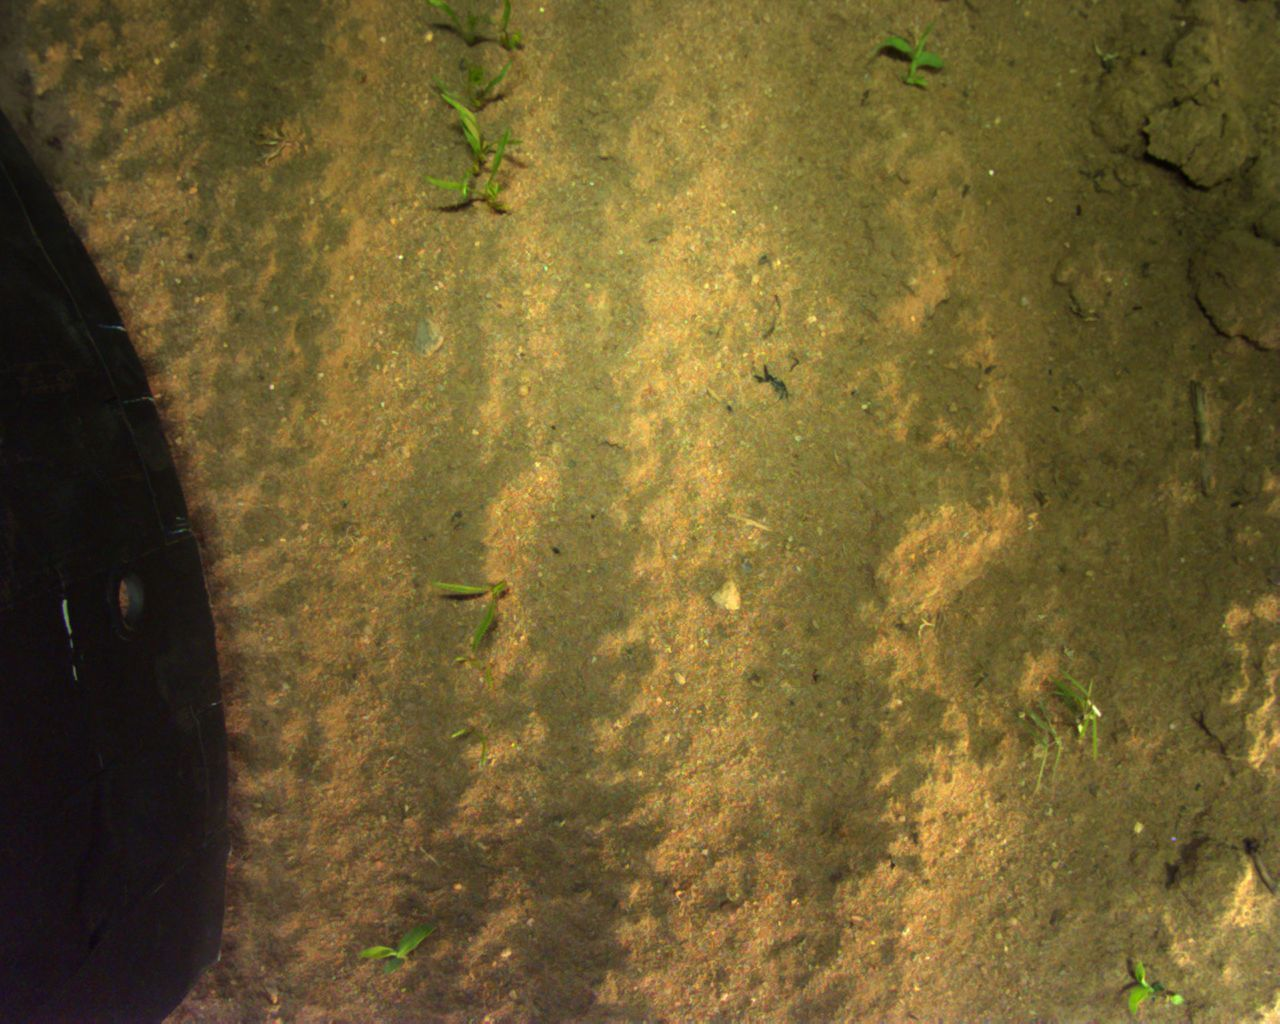

In [43]:
image = Image.open(mp+"My Drive/NEXUS/Nexus Week " + WEEK_ID + " (Complete)/images/training/1565561922505012000-overhead-image.png")
image

In [44]:
# prepare the image for the model
pixel_values = image_processor(image, return_tensors="pt").pixel_values.to(device)
print(pixel_values.shape)

torch.Size([1, 3, 512, 512])


In [45]:
import torch

# forward pass
with torch.no_grad():
  outputs = model(pixel_values=pixel_values)

In [46]:
# logits are of shape (batch_size, num_labels, height/4, width/4)
logits = outputs.logits.cpu()
print(logits.shape)

torch.Size([1, 3, 128, 128])


In [47]:
predicted_segmentation_map = image_processor.post_process_semantic_segmentation(outputs, target_sizes=[image.size[::-1]])[0]
predicted_segmentation_map = predicted_segmentation_map.cpu().numpy()
print(predicted_segmentation_map)

[[1 1 1 ... 1 1 1]
 [1 1 1 ... 1 1 1]
 [1 1 1 ... 1 1 1]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


In [48]:
import numpy as np
#from PIL import Image

def class_to_rgb(label_map, color_map):
    """
    Converts a class label map (H, W) back to an RGB segmentation map (H, W, 3).

    Args:
        label_map (np.ndarray): 2D array of class labels with shape (H, W).
        color_map (dict): Dictionary mapping class IDs to RGB values.

    Returns:
        PIL.Image: RGB segmentation map.
    """
    # Create an empty RGB image
    rgb_seg_map = np.zeros((label_map.shape[0], label_map.shape[1], 3), dtype=np.uint8)

    # Assign colors based on class IDs
    for class_id, rgb_color in color_map.items():
        mask = label_map == class_id  # Boolean mask for class pixels
        rgb_seg_map[mask] = rgb_color

    # Convert NumPy array to PIL image
    return Image.fromarray(rgb_seg_map)

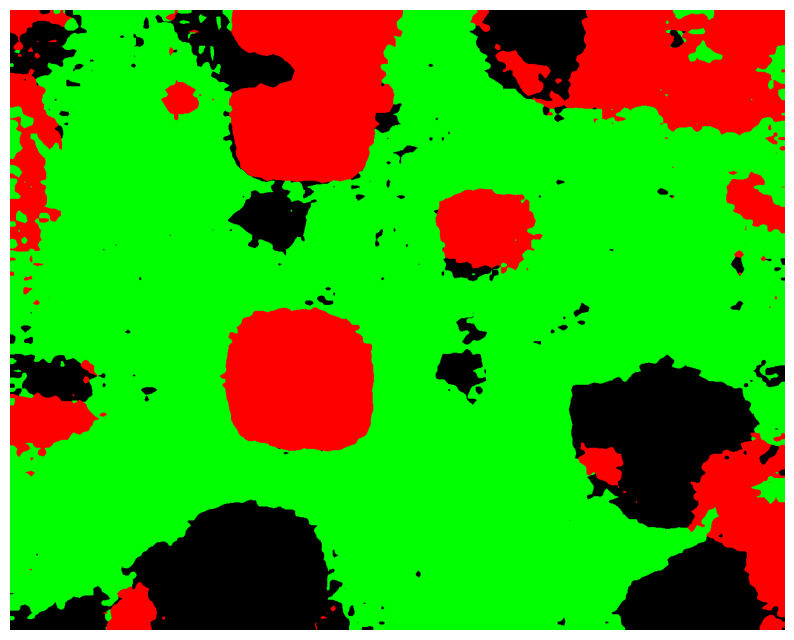

In [49]:
import matplotlib.pyplot as plt
#import numpy as np
'''
color_seg = np.zeros((predicted_segmentation_map.shape[0],
                      predicted_segmentation_map.shape[1], 3), dtype=np.uint8) # height, width, 3

palette = np.array(predicted_segmentation_map*255)
#palette = np.array(ade_palette())
for label, color in enumerate(palette):
    color_seg[predicted_segmentation_map == label, :] = color
# Convert to BGR
color_seg = color_seg[..., ::-1]

# Show image + mask
img = np.array(image) * 0.5 + color_seg * 0.5
img = img.astype(np.uint8)
'''

REVERSE_COLOR_MAP = {
    0: (0, 0, 0),        # Background - Black
    1: (255, 0, 0),      # Weed - Red
    2: (0, 255, 0),      # Crop - Green

}

predicted_segmentation_img = class_to_rgb(predicted_segmentation_map, REVERSE_COLOR_MAP)
predicted_segmentation_img.show()

# Display the image correctly in any environment
plt.figure(figsize=(10, 10))  # Adjust figure size
plt.imshow(predicted_segmentation_img)
plt.axis("off")  # Hide axes
plt.show()


Compare this to the ground truth segmentation map:

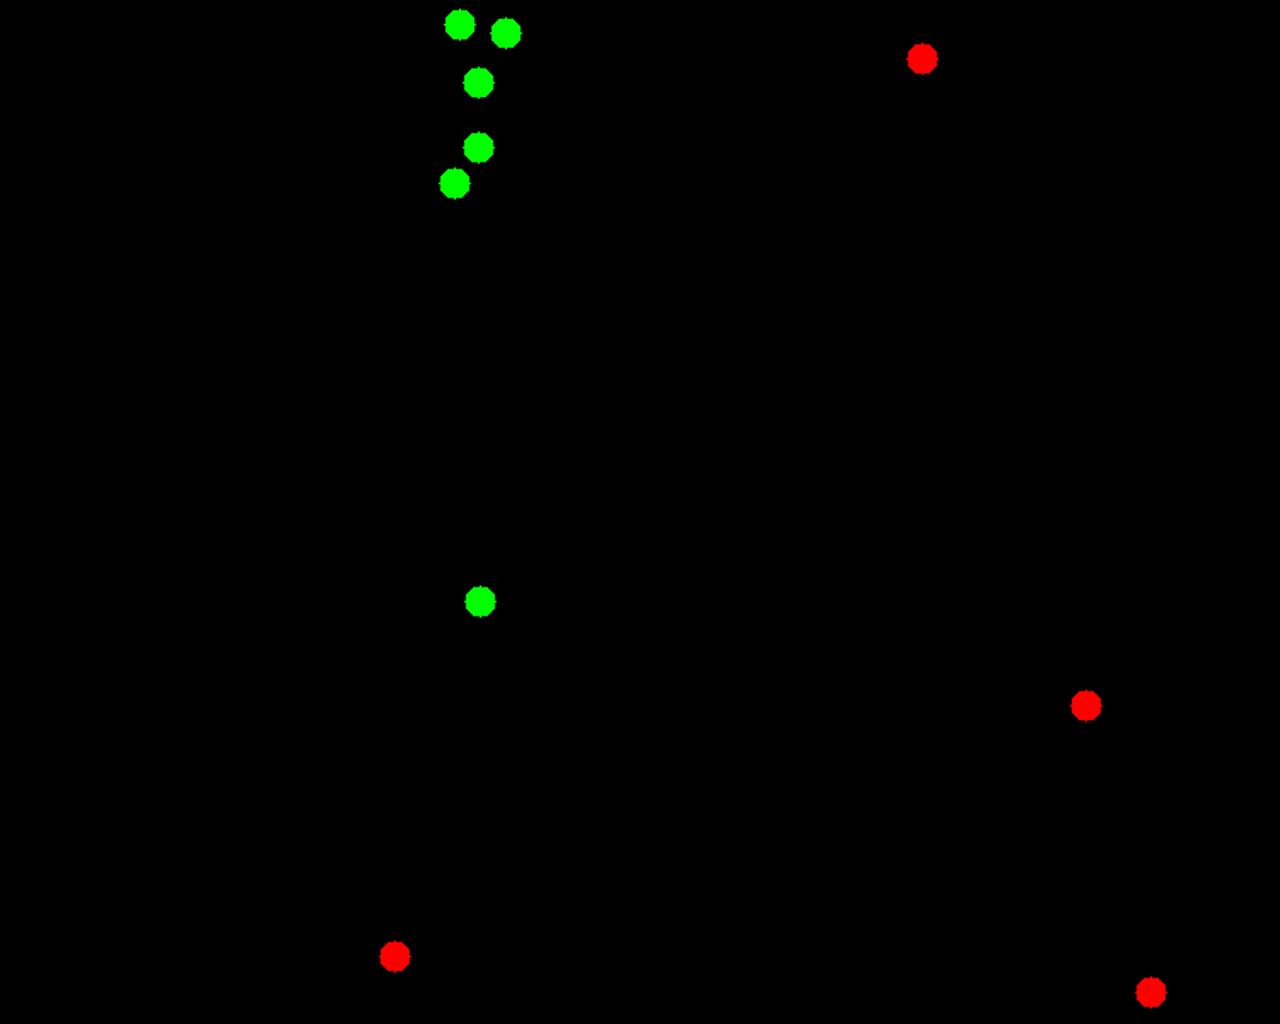

In [50]:
true_map = Image.open(mp+"My Drive/NEXUS/Nexus Week " + WEEK_ID + " (Complete)/annotations/training/1565561922505012000-overhead-image.png")
true_map

In [51]:
# convert map to NumPy array
map = np.array(true_map)
map[map == 0] = 255 # background class is replaced by ignore_index
map = map - 1 # other classes are reduced by one
map[map == 254] = 255

classes_map = np.unique(map).tolist()
unique_classes = [model.config.id2label[idx] if idx!=255 else None for idx in classes_map]
print("Classes in this image:", unique_classes)

# create coloured map
color_seg = np.zeros((map.shape[0], map.shape[1], 3), dtype=np.uint8) # height, width, 3
palette = np.array(ade_palette())
for label, color in enumerate(palette):
    color_seg[map == label, :] = color
# Convert to BGR
color_seg = color_seg[..., ::-1]

# Show image + mask
img = np.array(image) * 0.5 + color_seg * 0.5
img = img.astype(np.uint8)

plt.figure(figsize=(15, 10))
plt.imshow(img)
plt.show()

KeyError: 3

Let's compute the metrics:

In [ ]:
# metric expects a list of numpy arrays for both predictions and references
metrics = metric._compute(
                  predictions=[predicted_segmentation_map],
                  references=[true_map],
                  num_labels=len(id2label),
                  ignore_index=255,
                  reduce_labels=False, # we've already reduced the labels ourselves
              )

IndexError: too many indices for array: array is 2-dimensional, but 3 were indexed

In [ ]:
metrics.keys()

In [ ]:
import pandas as pd

# print overall metrics
for key in list(metrics.keys())[:3]:
  print(key, metrics[key])

# pretty-print per category metrics as Pandas DataFrame
metric_table = dict()
for id, label in id2label.items():
    metric_table[label] = [
                           metrics["per_category_iou"][id],
                           metrics["per_category_accuracy"][id]
    ]

print("---------------------")
print("per-category metrics:")
pd.DataFrame.from_dict(metric_table, orient="index", columns=["IoU", "accuracy"])